## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Loading the Dataset

In [3]:
# Read the JSON file into a list of JSON objects with the specified encoding
with open("yelp_academic_dataset_review.json", "r", encoding="utf-8") as json_file:
    data = [json.loads(line) for line in json_file]

# Create a DataFrame from the list of JSON objects
df = pd.DataFrame(data)


In [4]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


## Exploratory Data Analysis

In [5]:
df.shape

(6685900, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 459.1+ MB


In [7]:
df.describe()

,stars,useful,funny,cool
count,6.685900e+06,6.685900e+06,6.685900e+06,6.685900e+06
mean,3.716199e+00,1.354134e+00,4.827667e-01,5.787708e-01
std,1.463643e+00,3.700192e+00,2.378646e+00,2.359024e+00
min,1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00
max,5.000000e+00,1.241000e+03,1.290000e+03,5.060000e+02


In [16]:
# Get the number of unique users and unique businesses
num_users = df["user_id"].nunique()
num_businesses = df["business_id"].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique businesses: {num_businesses}")

Number of unique users: 1637138
Number of unique businesses: 192606


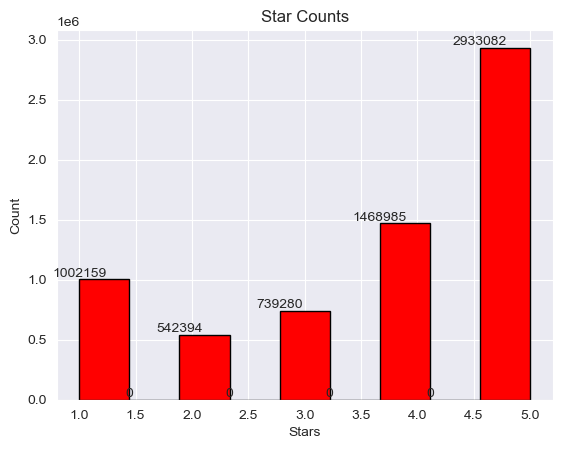

In [8]:
# Create a histogram (bar plot) with matplotlib
hist, bins, _ = plt.hist(df['stars'], bins=9, color='red', edgecolor='black')

# Add labels and title
plt.title("Star Counts")
plt.xlabel("Stars")
plt.ylabel("Count")

# Annotate the bars with counts
for i in range(len(hist)):
    plt.annotate(str(int(hist[i])), (bins[i], hist[i]), ha='center', va='bottom')

# Show the plot
plt.show()


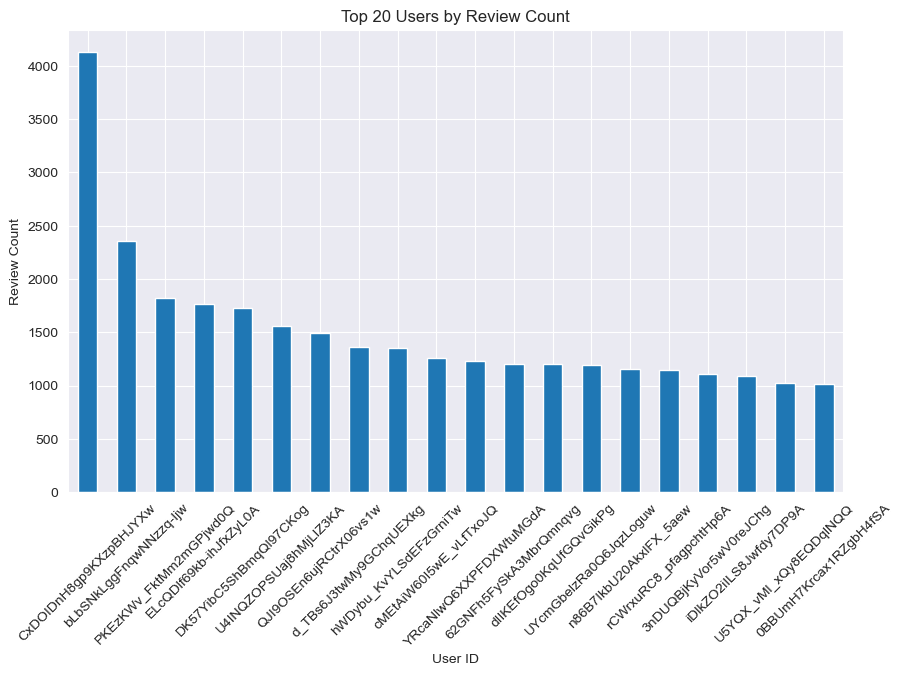

In [13]:
#Calculates the number of reviews made by each user in the dataset.
user_review_counts = df["user_id"].value_counts()

# Create a bar chart to visualize the user review counts
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
user_review_counts[:20].plot(kind='bar')
plt.xlabel("User ID")
plt.ylabel("Review Count")
plt.title("Top 20 Users by Review Count")
plt.xticks(rotation=45)
plt.show()

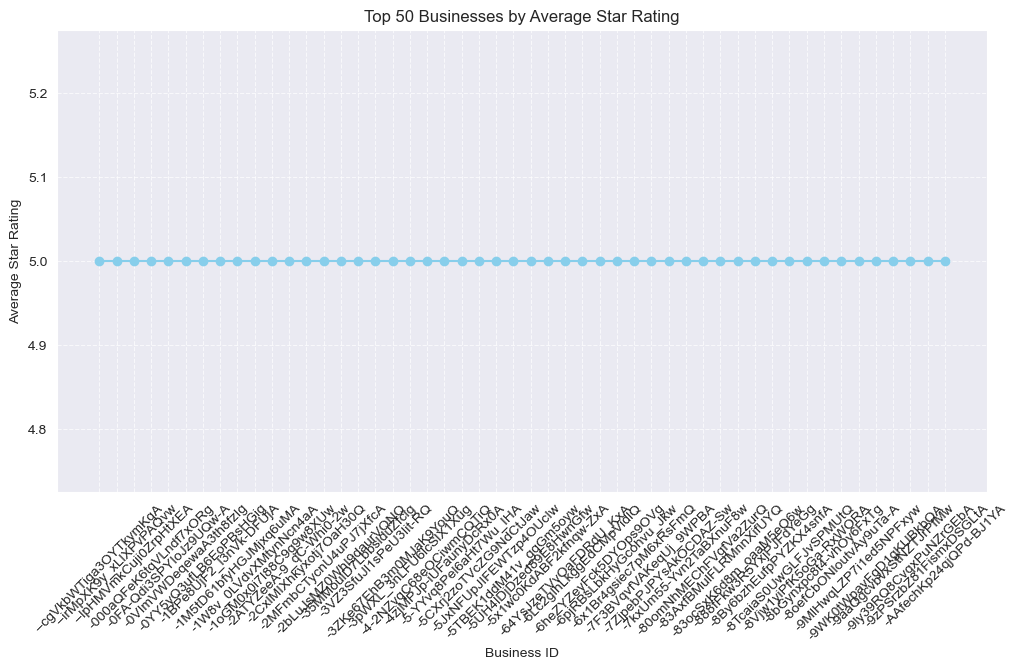

In [21]:
#Computes the average star rating given to each unique business in the dataset
average_ratings = df.groupby("business_id")["stars"].mean()

# Get the top 50 businesses by average star rating
top_50_businesses = average_ratings.nlargest(50)

# Create a line graph to visualize the average star ratings for the top 200 businesses
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(top_50_businesses.index, top_50_businesses.values, marker='o', color='skyblue', linestyle='-')
plt.xlabel("Business ID")
plt.ylabel("Average Star Rating")
plt.title("Top 50 Businesses by Average Star Rating")

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines for reference

plt.show()

In [24]:
# Calculate the number of businesses with each average star rating
num_5_stars = (average_ratings == 5).sum()
num_4_stars = (average_ratings == 4).sum()
num_3_stars = (average_ratings == 3).sum()
num_2_stars = (average_ratings == 2).sum()
num_1_star = (average_ratings == 1).sum()

# Print the counts
print(f"Number of businesses with an average rating of 5: {num_5_stars}")
print(f"Number of businesses with an average rating of 4: {num_4_stars}")
print(f"Number of businesses with an average rating of 3: {num_3_stars}")
print(f"Number of businesses with an average rating of 2: {num_2_stars}")
print(f"Number of businesses with an average rating of 1: {num_1_star}")

Number of businesses with an average rating of 5: 20216
Number of businesses with an average rating of 4: 7854
Number of businesses with an average rating of 3: 6792
Number of businesses with an average rating of 2: 3968
Number of businesses with an average rating of 1: 3960


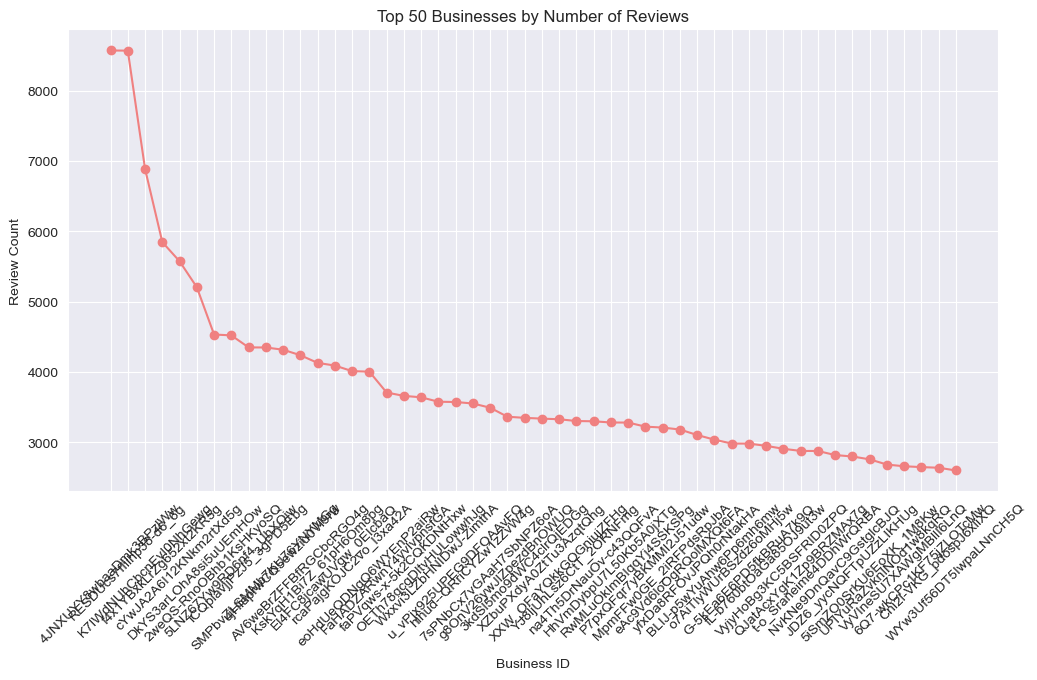

In [25]:
#Providing the number of reviews for each business
review_counts_per_business = df["business_id"].value_counts()

# Get the top 50 businesses by the number of reviews
top_50_businesses = review_counts_per_business.nlargest(50)

# Create a line chart to visualize the number of reviews for the top 50 businesses
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(top_50_businesses.index, top_50_businesses.values, marker='o', color='lightcoral', linestyle='-')
plt.xlabel("Business ID")
plt.ylabel("Review Count")
plt.title("Top 50 Businesses by Number of Reviews")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

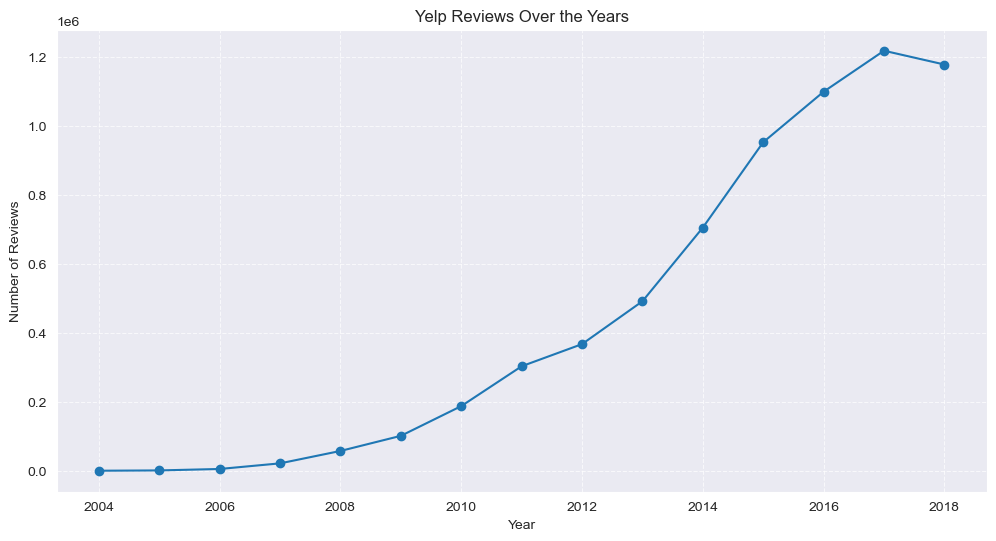

In [27]:
df['date'] = pd.to_datetime(df['date'])

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# Group by year and count the number of reviews per year
reviews_per_year = df.groupby(df['year']).size()

# Create a time series plot for the number of reviews per year
plt.figure(figsize=(12, 6))
plt.plot(reviews_per_year.index, reviews_per_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Yelp Reviews Over the Years')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


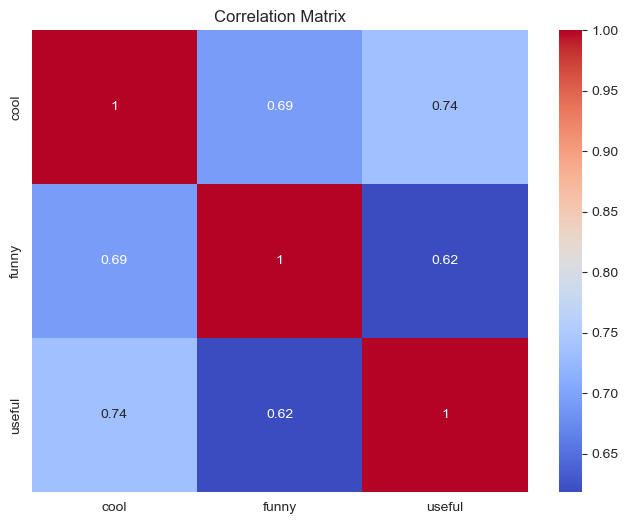

In [29]:
# Calculate and visualize the correlations between 'cool', 'funny', and 'useful'
correlation_matrix = df[['cool', 'funny', 'useful']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [30]:
# Identify top users with the most 'cool' ratings
top_cool_reviewers = df.groupby('user_id')['cool'].sum().nlargest(10)

# Display the top reviewers
print("Top Users with the Most 'Cool' Ratings:")
print(top_cool_reviewers)


Top Users with the Most 'Cool' Ratings:
user_id
zFYs8gSUYDvXkb6O7YkRkw    28947
PGeiszoVusiv0wTHVdWklA    20778
bLbSNkLggFnqwNNzzq-Ijw    20246
DK57YibC5ShBmqQl97CKog    19490
Fv0e9RIV9jw5TX3ctA1WbA    16722
PcvbBOCOcs6_suRDH7TSTg    15313
M9rRM6Eo5YbKLKMG5QiIPA    14447
8DEyKVyplnOcSKx39vatbg    12946
I-4KVZ9lqHhk8469X9FvhA    12555
A0j21z2Q1HGic7jW6e9h7A    11102
Name: cool, dtype: int64


In [33]:
# Identify top users with the most 'funny' ratings
top_funny_reviewers = df.groupby('user_id')['funny'].sum().nlargest(10)

# Display the top reviewers
print("Top Users with the Most 'Funny' Ratings:")
print(top_funny_reviewers)


Top Users with the Most 'Funny' Ratings:
user_id
zFYs8gSUYDvXkb6O7YkRkw    21768
bLbSNkLggFnqwNNzzq-Ijw    15004
Fv0e9RIV9jw5TX3ctA1WbA    12281
DK57YibC5ShBmqQl97CKog    12196
PGeiszoVusiv0wTHVdWklA    11492
8DEyKVyplnOcSKx39vatbg    11440
M9rRM6Eo5YbKLKMG5QiIPA     9292
rCWrxuRC8_pfagpchtHp6A     9126
A0j21z2Q1HGic7jW6e9h7A     8806
PcvbBOCOcs6_suRDH7TSTg     8380
Name: funny, dtype: int64


In [34]:
# Identify top users with the most 'useful' ratings
top_useful_reviewers = df.groupby('user_id')['useful'].sum().nlargest(10)

# Display the top reviewers
print("Top Users with the Most 'Useful' Ratings:")
print(top_useful_reviewers)


Top Users with the Most 'Useful' Ratings:
user_id
zFYs8gSUYDvXkb6O7YkRkw    30835
bLbSNkLggFnqwNNzzq-Ijw    29361
PGeiszoVusiv0wTHVdWklA    23367
DK57YibC5ShBmqQl97CKog    22699
Fv0e9RIV9jw5TX3ctA1WbA    18596
M9rRM6Eo5YbKLKMG5QiIPA    16789
8DEyKVyplnOcSKx39vatbg    16381
PcvbBOCOcs6_suRDH7TSTg    16183
CxDOIDnH8gp9KXzpBHJYXw    14151
PKEzKWv_FktMm2mGPjwd0Q    14059
Name: useful, dtype: int64


In [35]:
top_N = 10  # Top 10 'useful' reviews

# Sort the dataset by the "useful" column in descending order
top_useful_reviews = df.sort_values(by='useful', ascending=False).head(top_N)

# Display the top N reviews and their associated text
print("Top {} Reviews with the Most 'Useful' Counts:".format(top_N))
for index, row in top_useful_reviews.iterrows():
    print("Review ID: ", row['review_id'])
    print("Useful Count: ", row['useful'])
    print("Review Text: ", row['text'])
    print("\n")


Top 10 Reviews with the Most 'Useful' Counts:
Review ID:  4ZN5ZWVoGd8er9giAKgV-g
Useful Count:  1241
Review Text:  Dinner for 1.

- Preface
I went to Amy's Baking Company with an open mind. After all, reality TV does have a tendency to make things appear more extreme. However, I was nervous. What if Samy smelled a Yelper?  There were many things I was afraid to order. Damn you Kitchen Nightmares. While the menu is filled with gnocchi choices, I deviated since I didn't want to eat non-refrigerated, packaged gnocchi. The burger was out since it looked like a greasy mess. And I didn't like the idea of eating raw dough, so no pizza. They were out of soup that night, which I found mildly annoying. In order to write an objective review, it was important to me to remain a neutral, regular customer, with no unnecessary provoking. 

- Ambiance (4/5)
ABC is clean and chic, but quite empty inside. I was 1 of 3 tables. Perhaps it would have been excusable, except the place next door was quite busy

### For More Deep Analysis - Creating Features

Here, we created the "Customer Experience" column, where we categorise the Stars provided to various businesses as GOOD, BAD, or NEUTRAL.

In addition, we created a new feature called "Text Length", which shows the length of the reviews. This functionality will help us understand consumer behaviour and experiences.

In [36]:
# Create a function to categorize star ratings
def categorize_customer_exp(rating):
    if rating == 1:
        return 'BAD'
    elif rating in (2, 3):
        return 'NEUTRAL'
    else:
        return 'GOOD'

# Apply the function to create the 'Customer EXP' column
df['Customer EXP'] = df['stars'].apply(categorize_customer_exp)

# Count the values in the 'Customer EXP' column
customer_exp_counts = df['Customer EXP'].value_counts()

# Calculate text length and create the 'Text length' column
df['Text length'] = df['text'].apply(lambda x: len(x.split()))

# Display the first few rows of the DataFrame
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,Customer EXP,Text length
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36,2013,BAD,39
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33,2017,GOOD,274
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03,2016,GOOD,109
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38,2018,GOOD,68
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38,2018,BAD,673


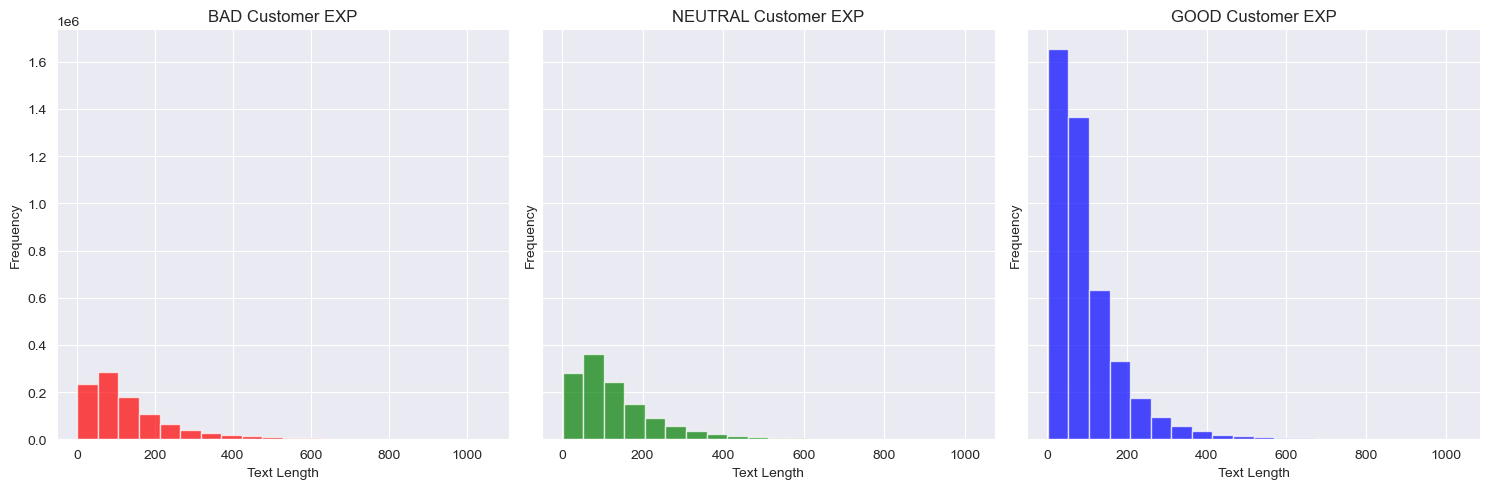

Mean Text Length by Customer EXP:
Customer EXP
BAD        143.158436
GOOD        97.205362
NEUTRAL    136.280202
Name: Text length, dtype: float64


In [38]:
# Create separate data frames for each "Customer EXP" category
bad_reviews = df[df['Customer EXP'] == 'BAD']
neutral_reviews = df[df['Customer EXP'] == 'NEUTRAL']
good_reviews = df[df['Customer EXP'] == 'GOOD']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Plot histograms for text length in each "Customer EXP" category
for i, (category, color) in enumerate(zip(['BAD', 'NEUTRAL', 'GOOD'], ['red', 'green', 'blue'])):
    ax = axes[i]
    ax.hist(df[df['Customer EXP'] == category]['Text length'], bins=20, color=color, alpha=0.7)
    ax.set_title(f'{category} Customer EXP')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate and display the mean text length for each "Customer EXP" category
mean_text_length = df.groupby('Customer EXP')['Text length'].mean()
print("Mean Text Length by Customer EXP:")
print(mean_text_length)


The density distributions and histograms of text lengths for reviews designated as GOOD, BAD, and NEUTRAL are shown in the graph above. People who rate a business as BAD or NEUTRAL have roughly 150 words in their evaluations, but people who are supposed to assess the business as GOOD have approximately 100 words in their reviews.


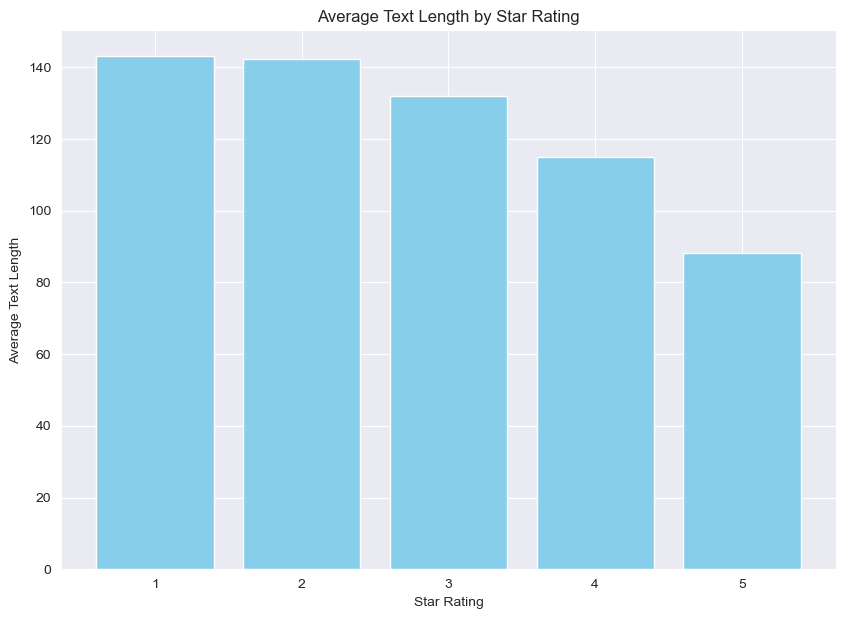

In [39]:
# Calculate the average text length for each star rating
average_text_length = df.groupby('stars')['Text length'].mean()

# Create a bar chart
plt.figure(figsize=(10, 7))
plt.bar(average_text_length.index, average_text_length.values, color='skyblue')
plt.xlabel('Star Rating')
plt.ylabel('Average Text Length')
plt.title('Average Text Length by Star Rating')
plt.xticks(average_text_length.index)
plt.show()


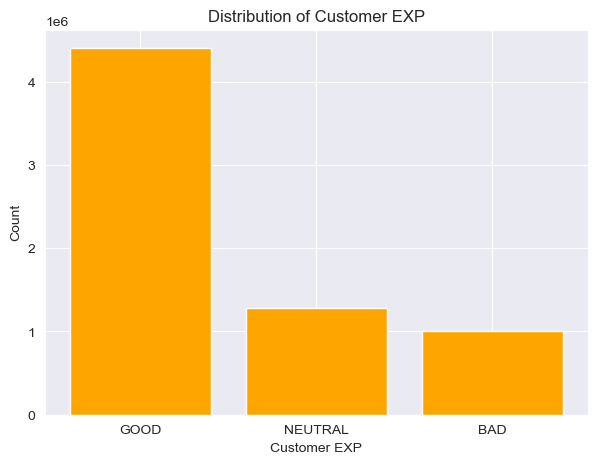

In [40]:
# Count the number of reviews in each "Customer EXP" category
customer_exp_counts = df['Customer EXP'].value_counts()

# Create a countplot using matplotlib
plt.figure(figsize=(7, 5))
plt.bar(customer_exp_counts.index, customer_exp_counts.values, color='orange')
plt.xlabel('Customer EXP')
plt.ylabel('Count')
plt.title('Distribution of Customer EXP')
plt.show()


In [42]:
#When we categorise the data set by STARS, we can find the correlation between COOL, USEFUL, FUNNY, and TEXT_LENGTH characteristics after adding the TEXT_LENGTH feature

# Select the columns of interest for correlation
columns_of_interest = ['stars', 'cool', 'funny', 'useful', 'Text length']

# Calculate the correlation between the selected columns by 'Customer EXP'
correlation_matrix = df.groupby('Customer EXP')[columns_of_interest].mean().corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                stars      cool     funny    useful  Text length
stars        1.000000  0.934987 -0.905719 -0.964968    -0.954197
cool         0.934987  1.000000 -0.696493 -0.995290    -0.786047
funny       -0.905719 -0.696493  1.000000  0.762778     0.991050
useful      -0.964968 -0.995290  0.762778  1.000000     0.842274
Text length -0.954197 -0.786047  0.991050  0.842274     1.000000


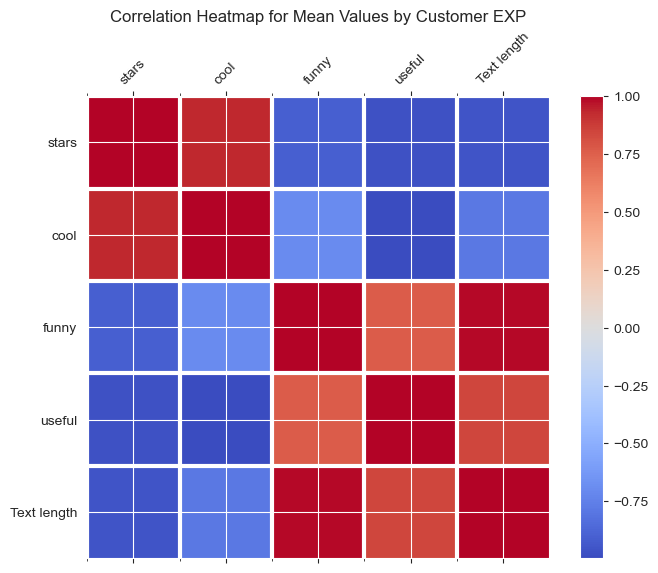

In [44]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)

# Customize the heatmap
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)
ax.set_xticks(np.arange(-0.5, len(correlation_matrix.columns)-0.5, 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(correlation_matrix.index)-0.5, 1), minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
plt.title('Correlation Heatmap for Mean Values by Customer EXP')
plt.show()

## Preprocessing of the Dataset

In [9]:
#Removing the Unwanted Columns
required_columns = ['review_id','stars','text']
df_new = df[required_columns ]
df_new.head()

,review_id,stars,text
0,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...
1,GJXCdrto3ASJOqKeVWPi6Q,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,2TzJjDVDEuAW6MR5Vuc1ug,5.0,I have to say that this office really has it t...
3,yi0R0Ugj_xUx_Nek0-_Qig,5.0,Went in for a lunch. Steak sandwich was delici...
4,11a8sVPMUFtaC7_ABRkmtw,1.0,Today was my second out of three sessions I ha...


In [11]:
#Checking for Duplicate Reviews
duplicate_rows = df.duplicated()

# Check if any duplicates exist
if duplicate_rows.any():
    print("There are duplicate rows in the DataFrame.")
else:
    print("No duplicate rows found in the DataFrame.")


No duplicate rows found in the DataFrame.
